In [1]:

# Dataframe and Plotting libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Machine Learning libraries
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier, XGBRegressor, XGBRFRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss



pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')

# Load the Dataset

In [2]:
# Load the files into a Pandas Dataframe
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')
d = pd.read_csv('extra_data.csv')

In [3]:
test['Transaction_ID'] == 'ID_00x9h2yx'

0       True
1      False
2      False
3      False
4      False
       ...  
553    False
554    False
555    False
556    False
557    False
Name: Transaction_ID, Length: 558, dtype: bool

In [4]:
# print the shape of the datasets.
print('Train data shape :', train.shape)
print('Test data shape :', test.shape)

Train data shape : (373, 12)
Test data shape : (558, 11)


In [5]:
d.USER_ID.nunique()

39

## 2. Understand the dataset

In [6]:
train.MERCHANT_NAME.nunique()

218

<Axes: >

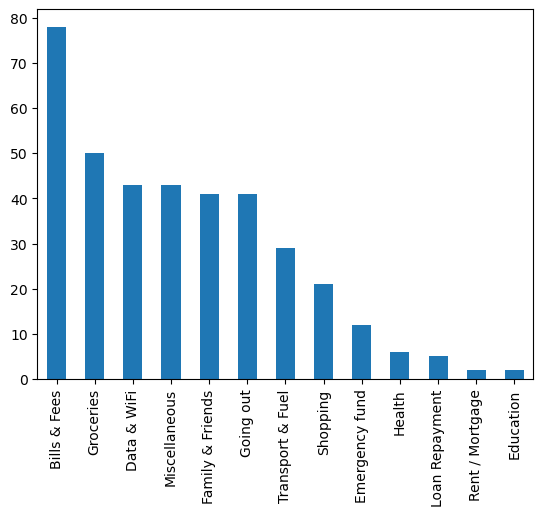

In [7]:
train.MERCHANT_CATEGORIZED_AS.value_counts().plot(kind='bar')

<BarContainer object of 13 artists>

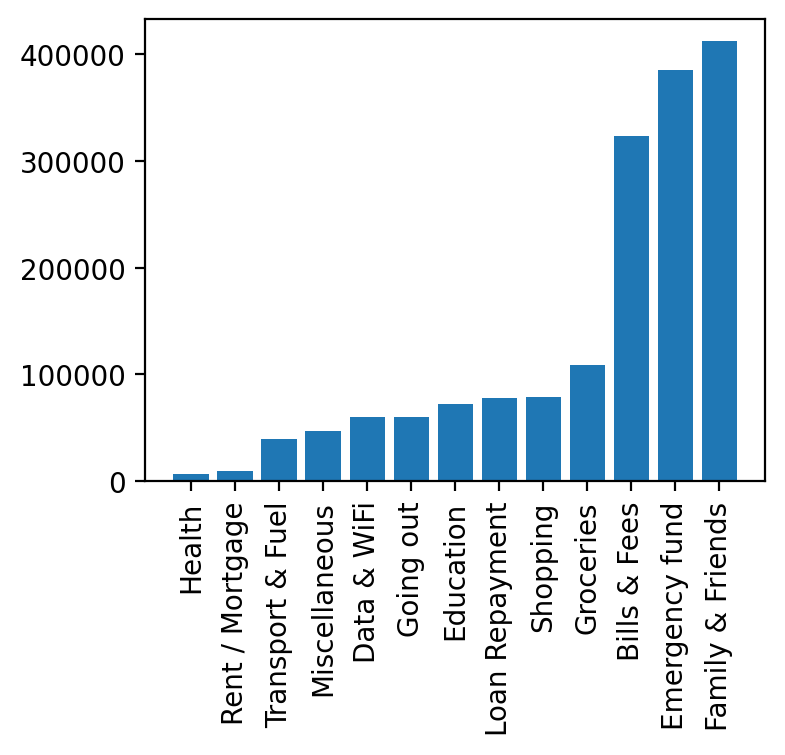

In [8]:
data = pd.pivot_table(train, values='PURCHASE_VALUE', index='MERCHANT_CATEGORIZED_AS', aggfunc='sum').reset_index(False)
data = data.sort_values('PURCHASE_VALUE')
# Bar graph of the purchase_value vs the target
plt.figure(dpi=200, figsize=(4,3))
plt.xticks(rotation=90)
plt.bar(data=data, x='MERCHANT_CATEGORIZED_AS', height='PURCHASE_VALUE')

In [9]:
labels_train = train['MERCHANT_CATEGORIZED_AS'].astype('category').cat.categories.tolist()
replace_map_train = {'MERCHANT_CATEGORIZED_AS' : {k: v for k,v in zip(labels_train,list(range(0,len(labels_train)+1)))}}
print("Train data: ", replace_map_train)

Train data:  {'MERCHANT_CATEGORIZED_AS': {'Bills & Fees': 0, 'Data & WiFi': 1, 'Education': 2, 'Emergency fund': 3, 'Family & Friends': 4, 'Going out': 5, 'Groceries': 6, 'Health': 7, 'Loan Repayment': 8, 'Miscellaneous': 9, 'Rent / Mortgage': 10, 'Shopping': 11, 'Transport & Fuel': 12}}


In [10]:
train_data_corr = train.copy()

In [11]:
# We can also use the .isnull() method to check for empty values
print('Missing values for Train:', train.isnull().sum())
print('')
print('Missing values for Test:', test.isnull().sum())

Missing values for Train: MERCHANT_CATEGORIZED_AT                    0
MERCHANT_NAME                              0
MERCHANT_CATEGORIZED_AS                    0
PURCHASE_VALUE                             0
PURCHASED_AT                               0
IS_PURCHASE_PAID_VIA_MPESA_SEND_MONEY      0
USER_AGE                                 312
USER_GENDER                                6
USER_HOUSEHOLD                             0
USER_INCOME                                0
USER_ID                                    0
Transaction_ID                             0
dtype: int64

Missing values for Test: MERCHANT_CATEGORIZED_AT                    0
MERCHANT_NAME                              0
PURCHASE_VALUE                             0
PURCHASED_AT                               0
IS_PURCHASE_PAID_VIA_MPESA_SEND_MONEY      0
USER_AGE                                 473
USER_GENDER                                5
USER_HOUSEHOLD                             0
USER_INCOME                        

In [12]:
train[train['USER_GENDER'].isnull()]

,MERCHANT_CATEGORIZED_AT,MERCHANT_NAME,MERCHANT_CATEGORIZED_AS,PURCHASE_VALUE,PURCHASED_AT,IS_PURCHASE_PAID_VIA_MPESA_SEND_MONEY,USER_AGE,USER_GENDER,USER_HOUSEHOLD,USER_INCOME,USER_ID,Transaction_ID
35,2021-11-30 10:51:36.702996+00,IDEAL APPLIANCES,Bills & Fees,24995,2021-05-06 14:14:00+00,False,NaN,NaN,1,10000,ID_R4T8Q46J,ID_3xlptxy6
137,2021-11-30 10:52:38.553994+00,QUICK MART,Shopping,3298,2021-06-19 15:05:00+00,False,NaN,NaN,1,10000,ID_R4T8Q46J,ID_dhp3d403
280,2021-08-06 11:28:03.723042+00,EQUITY PAYBILL,Shopping,4000,2021-07-25 10:54:00+00,True,NaN,NaN,1,10000,ID_R4T8Q46J,ID_qvgzrt0r
309,2021-11-30 10:52:38.553994+00,NAOMI WANJOHI,Family & Friends,1028,2021-05-13 14:28:00+00,True,NaN,NaN,1,10000,ID_R4T8Q46J,ID_u02b0hl6
312,2021-11-30 10:51:36.702996+00,POA,Data & WiFi,1500,2021-07-21 17:46:00+00,False,NaN,NaN,1,10000,ID_R4T8Q46J,ID_uvhgthza
361,2021-11-30 10:51:36.702996+00,MIRIAM MUNGAI,Family & Friends,1600,2021-06-11 18:25:00+00,True,NaN,NaN,1,10000,ID_R4T8Q46J,ID_yxz5etfz


In [13]:
test[test['USER_GENDER'].isnull()]

,MERCHANT_CATEGORIZED_AT,MERCHANT_NAME,PURCHASE_VALUE,PURCHASED_AT,IS_PURCHASE_PAID_VIA_MPESA_SEND_MONEY,USER_AGE,USER_GENDER,USER_HOUSEHOLD,USER_INCOME,USER_ID,Transaction_ID
124,2021-08-06 11:28:16.857538+00,ACCESS AFYA,1,2021-08-05 09:32:00+00,False,NaN,NaN,1,10000,ID_R4T8Q46J,ID_8oyhw5j0
138,2021-11-30 10:51:36.702996+00,PETER INDIMULI,1028,2021-04-08 12:07:00+00,True,NaN,NaN,1,10000,ID_R4T8Q46J,ID_9au0g3qv
374,2021-11-30 10:51:36.702996+00,MICHELLE RODROT,827,2021-07-22 13:36:00+00,True,NaN,NaN,1,10000,ID_R4T8Q46J,ID_p5ajidvp
395,2021-11-30 10:51:36.702996+00,DORCAS WANJOHI,2600,2021-06-07 14:05:00+00,True,NaN,NaN,1,10000,ID_R4T8Q46J,ID_qd7dgqor
550,2021-11-30 10:52:38.553994+00,POA,1500,2021-05-22 19:11:00+00,False,NaN,NaN,1,10000,ID_R4T8Q46J,ID_zqi8lti6


In [14]:
train.USER_GENDER.value_counts()

Male      197
Female    170
Name: USER_GENDER, dtype: int64

In [15]:
test.USER_GENDER.value_counts()

Male      307
Female    246
Name: USER_GENDER, dtype: int64

# Replace missing value

In [16]:
train["USER_GENDER"] = train["USER_GENDER"].apply(lambda x: "Male" if pd.isna(x) else x)
test["USER_GENDER"] = test["USER_GENDER"].apply(lambda x: "Male" if pd.isna(x) else x)

In [17]:
# Impute the missing age entries with the median of that column
train_median_value = np.median(train['USER_AGE'].dropna())
train['USER_AGE'] = train['USER_AGE'].fillna(train_median_value)

test_median_value = np.median(test['USER_AGE'].dropna())
test['USER_AGE'] = test['USER_AGE'].fillna(test_median_value)

In [18]:
train["train"] = 1
test["train"] = 0

In [19]:
all_data = pd.concat([train, test])

In [20]:
all_data = pd.get_dummies(all_data, prefix_sep="_", columns=['MERCHANT_NAME'])

In [21]:
train = all_data[all_data["train"] == 1]
test = all_data[all_data["train"] == 0]

In [22]:
print("Train: ", train.shape)
print("Test: ", test.shape)

Train:  (373, 452)
Test:  (558, 452)


In [23]:
train = train.drop(['MERCHANT_CATEGORIZED_AT','PURCHASED_AT','USER_ID', 'Transaction_ID', "train"], axis=1)
test = test.drop(['MERCHANT_CATEGORIZED_AT','PURCHASED_AT','USER_ID', "train", "MERCHANT_CATEGORIZED_AS"], axis=1)

In [24]:
# Based on our data set, this function converts boolean to binary entries
def create_binary_cols(content):
  if content == False:
    content = 0
  elif content == True:
    content = 1
  elif content == 'N':
    content = 0
  elif content == 'Y':
    content = 1
  elif content == 'Male':
    content = 0
  elif content == 'Female':
    content = 1
  return content

In [25]:
# Gender column convert:
train['USER_GENDER'] = train['USER_GENDER'].apply(create_binary_cols)
test['USER_GENDER'] = test['USER_GENDER'].apply(create_binary_cols)

# Is_purchase_paid_via_mpesa_send_money column convert:
train['IS_PURCHASE_PAID_VIA_MPESA_SEND_MONEY'] = train['IS_PURCHASE_PAID_VIA_MPESA_SEND_MONEY'].apply(create_binary_cols)
test['IS_PURCHASE_PAID_VIA_MPESA_SEND_MONEY'] = test['IS_PURCHASE_PAID_VIA_MPESA_SEND_MONEY'].apply(create_binary_cols)

In [26]:
#Separate the features from the target in the training data
X = train.drop(["MERCHANT_CATEGORIZED_AS"], axis=1)
y = train["MERCHANT_CATEGORIZED_AS"]

In [27]:
X

,PURCHASE_VALUE,IS_PURCHASE_PAID_VIA_MPESA_SEND_MONEY,USER_AGE,USER_GENDER,USER_HOUSEHOLD,USER_INCOME,MERCHANT_NAME_ABSA BANK KENYA PLC,MERCHANT_NAME_ACCESS AFYA,MERCHANT_NAME_AGGREY MWANGALE,MERCHANT_NAME_AGNES KASYOKI,MERCHANT_NAME_AGNES NGANGA,MERCHANT_NAME_ALBERT MBOGO,MERCHANT_NAME_ALCHEMIIST - LEGEND BAR,MERCHANT_NAME_ALEX SAKWA,MERCHANT_NAME_ALLAN WAMBURA,MERCHANT_NAME_ALLSTAR GAS SUPPLIES,MERCHANT_NAME_ALMA APARTMENTS MANAGEMENT CO LTD,MERCHANT_NAME_ALPHA CAR WASH,MERCHANT_NAME_AMBROSE MWALILI,MERCHANT_NAME_ANASTACIA CHEROBON,MERCHANT_NAME_ANKOLE GRILL LIMITED,MERCHANT_NAME_ANTONY MAKAU,MERCHANT_NAME_APS ABC PARKING,MERCHANT_NAME_ARDEN AXIDA ABUOCH,MERCHANT_NAME_ARNELLE OMONDI,MERCHANT_NAME_ARNICA PHARMACEUTICALS,MERCHANT_NAME_ART MARKET KILELESHWA,MERCHANT_NAME_ARTCAFFE TWO RIVERS,MERCHANT_NAME_ASHAKI GRILL AND BBQ,MERCHANT_NAME_ASL TD,MERCHANT_NAME_AUDRINE MAKAKA,MERCHANT_NAME_BAABAX EXPRESS LIMITED,MERCHANT_NAME_BARISTAPRO KENYA LTD,MERCHANT_NAME_BATA,MERCHANT_NAME_BAYES,MERCHANT_NAME_BERNARD NDUNG'U,MERCHANT_NAME_BETH GICHU,MERCHANT_NAME_BETHSEBA MAKOKHA,MERCHANT_NAME_BETHSHEBA NYAUNDI,MERCHANT_NAME_BIG FISH,MERCHANT_NAME_BILLY OMOLO,MERCHANT_NAME_BLIZZ WINES AND SPIRITS DISTRIBUTORS,MERCHANT_NAME_BOLT FASHIONS,MERCHANT_NAME_BRAVINE SUNGAH STOWER,MERCHANT_NAME_BRIAN MUNANGWE,MERCHANT_NAME_BRIAN OKUKU,MERCHANT_NAME_BRIOCHE RUBIS LANGATA,MERCHANT_NAME_BUY DIRECT LIMITED 2,MERCHANT_NAME_CAFETERIA AND TIN TIN RESTAURANT,MERCHANT_NAME_CAKES BY EUDIE LIMITED,MERCHANT_NAME_CAPTON ENTERPRISES NRBI WEST,MERCHANT_NAME_CAPTURE ADVENTURES,MERCHANT_NAME_CAROLINE KURIA,MERCHANT_NAME_CARREFOUR,MERCHANT_NAME_CARREFOUR GLR,MERCHANT_NAME_CARREFOUR GLR,MERCHANT_NAME_CARREFOUR SRT,MERCHANT_NAME_CASH NOW CASHNOW,MERCHANT_NAME_CBD-680,MERCHANT_NAME_CECILIA MWANGI,MERCHANT_NAME_CEDRIC OCHOLA,MERCHANT_NAME_CETRICK MUKALAVAI,MERCHANT_NAME_CHANDARANA YAYA 1,MERCHANT_NAME_CHAPA COPY COMPANY - KILELESHWA,MERCHANT_NAME_CHARLENNE AKETCH OBBO ONYANGO,MERCHANT_NAME_CHRISPIN MALOBA,MERCHANT_NAME_CHRISTINE MUTISYA,MERCHANT_NAME_CHRISTINE OOKO,MERCHANT_NAME_CHRISTOHER ONGAYA,MERCHANT_NAME_CITAM BUSINESS FORUM CBF ON,MERCHANT_NAME_CITAM KAREN TITHE ON,MERCHANT_NAME_CITAM KITENGELA OFFERING ON,MERCHANT_NAME_CLAPPERTON MUSYOKI,MERCHANT_NAME_CLENICE MBECHE,MERCHANT_NAME_CO-OPERATIVE BANK COLLECTION ACCOUNT,MERCHANT_NAME_COCO JAMBO,MERCHANT_NAME_COLLINS OUMA,MERCHANT_NAME_CRAFT - CHUPA CHAP,MERCHANT_NAME_CREDITAREA CAPITAL LIMITED,MERCHANT_NAME_DAVID MWANIKI NJOKA,MERCHANT_NAME_DECATHLON HUB TILL 5,MERCHANT_NAME_DEEJINA LIMITED,MERCHANT_NAME_DEEPAL PATEL,MERCHANT_NAME_DENIS OCHIENG OTIENO,MERCHANT_NAME_DENIS OTIENO,MERCHANT_NAME_DESMOND MATIMU,MERCHANT_NAME_DIRECT PAY,MERCHANT_NAME_DORCAS WANJOHI,MERCHANT_NAME_DORINE ADHIAMBO,MERCHANT_NAME_DR CECILIA,MERCHANT_NAME_DUKE NYAMARI,MERCHANT_NAME_DUNCAN NDUGO,MERCHANT_NAME_DUNTON OKOTH,MERCHANT_NAME_EDWIN OMBATI,MERCHANT_NAME_ELIAS MBURU,MERCHANT_NAME_ELIVIN KWAMBOKA MOYWAYWA,MERCHANT_NAME_ELIZABETH NYAMBURA,MERCHANT_NAME_ELIZABETH WANGARI,MERCHANT_NAME_ENGEN KENYA,MERCHANT_NAME_ENOCK MAKORI,MERCHANT_NAME_ENVY VIVA CORPORATE,MERCHANT_NAME_EQUITY PAYBILL,MERCHANT_NAME_EQUITY PAYBILL ACCOUNT,MERCHANT_NAME_ERIC CHESI,MERCHANT_NAME_ESTHER NDIRITU,MERCHANT_NAME_ESTHER WANJIKU KARANJA,MERCHANT_NAME_FAHARI RETIREMENT PLAN,MERCHANT_NAME_FAMILY BANK PESA PAP,MERCHANT_NAME_FARMER'S CHOICE STOCKISTS,MERCHANT_NAME_FARMERS BUTCHERY,MERCHANT_NAME_FATHALLA ABOUBAKR,MERCHANT_NAME_FATUMA OSORE,MERCHANT_NAME_FAYAZ BAKERS KILIFI TOWN SHOP,MERCHANT_NAME_FELIX KAINDI,MERCHANT_NAME_FISH BAY,MERCHANT_NAME_FLORENCE KANANA,MERCHANT_NAME_FOUR SQUARE FINE CUTS,MERCHANT_NAME_FRACIAH KAGAI,MERCHANT_NAME_FRANCIS KABOCHI,MERCHANT_NAME_FREDRICK NGATIA,MERCHANT_NAME_FREDRICK OMENYO,MERCHANT_NAME_FRIDAH OWINO,MERCHANT_NAME_FYTY CARWASH,MERCHANT_NAME_GALITOS BELLEVUE,MERCHANT_NAME_GARIDON ENTERPRISES VIA CO-OP,MERCHANT_NAME_GEORGE GACHERU,MERCHANT_NAME_GEORGE KAMAU,MERCHANT_NAME_GHARIB HABIB,MERCHANT_NAME_GITHUNGURI SELFRIDGES SUPERMARKET,MERCH

In [28]:
from imblearn.over_sampling import SMOTE, ADASYN

X_resampled, y_resampled = SMOTE(k_neighbors=1).fit_resample(X, y)

In [29]:
# from mlxtend.classifier import StackingClassifier
# from sklearn.model_selection import KFold
# from catboost import CatBoostClassifier, Pool
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.model_selection import RepeatedStratifiedKFold

# from sklearn.multiclass import OneVsRestClassifier
# from sklearn.linear_model import LogisticRegression
# import lightgbm as lgb
# from sklearn.utils.class_weight import compute_class_weight
# from sklearn.svm import SVC

# kf = KFold(n_splits=5,random_state=42,shuffle=True)
# for i, (train_index, valid_index) in enumerate(kf.split(X_resampled,y_resampled)):

#     X_train, y_train = X_resampled.iloc[train_index], y_resampled.iloc[train_index]
#     X_val, y_val = X_resampled.iloc[valid_index], y_resampled.iloc[valid_index]


#     m =OneVsRestClassifier(StackingClassifier(
#         classifiers=[
#             LogisticRegression(),
#     CatBoostClassifier(
#          iterations=150,
#         #depth=11,
#         #use_best_model =True,
#         verbose =0,

#         task_type="GPU",
#             learning_rate=0.1,
#         early_stopping_rounds= 100
#     )    ],
#         use_probas=True,
#         meta_classifier=LogisticRegression()
#     ))





#     m.fit(X_train, y_train),
#     preds = m.predict_proba(X_val)
#     loss+=log_loss(y_val, preds)
#     print(f'log_loss: {log_loss(y_val, preds)}')
# print(loss/5)

In [30]:
X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, test_size=0.1, random_state=101)

In [31]:
# Creating a Decision tree classifier
model_dtree = DecisionTreeClassifier(max_depth=5, random_state=101,
                                     max_features = None, min_samples_leaf=8)

# Training the model on the training dataset
model_dtree.fit(X_train, y_train)

# Predict
y_pred = model_dtree.predict(X_val)

# Calculate accuracy
print("ACCURACY OF THE MODEL: ", accuracy_score(y_val, y_pred))

# Classification report
print(classification_report(y_val, y_pred))

ACCURACY OF THE MODEL:  0.29411764705882354
                  precision    recall  f1-score   support

    Bills & Fees       0.00      0.00      0.00        11
     Data & WiFi       1.00      0.29      0.44         7
       Education       1.00      0.86      0.92         7
  Emergency fund       1.00      0.33      0.50        12
Family & Friends       0.00      0.00      0.00        11
       Going out       0.00      0.00      0.00         5
       Groceries       0.00      0.00      0.00         5
          Health       1.00      0.20      0.33         5
  Loan Repayment       0.14      0.40      0.21         5
   Miscellaneous       0.11      1.00      0.19         6
 Rent / Mortgage       0.50      0.90      0.64        10
        Shopping       0.00      0.00      0.00        11
Transport & Fuel       0.00      0.00      0.00         7

        accuracy                           0.29       102
       macro avg       0.37      0.31      0.25       102
    weighted avg       0.3

In [32]:
from sklearn.ensemble import RandomForestClassifier

# Creating a RF classifier
clf = RandomForestClassifier()

# Training the model on the training dataset
clf.fit(X_train, y_train)

# Performing predictions on the test dataset
y_pred = clf.predict(X_val)

# Calculate accuracy
print("ACCURACY OF THE MODEL: ", accuracy_score(y_val, y_pred))

# Classification report
print(classification_report(y_val, y_pred))


ACCURACY OF THE MODEL:  0.7941176470588235
                  precision    recall  f1-score   support

    Bills & Fees       0.67      0.36      0.47        11
     Data & WiFi       0.86      0.86      0.86         7
       Education       1.00      1.00      1.00         7
  Emergency fund       0.77      0.83      0.80        12
Family & Friends       0.82      0.82      0.82        11
       Going out       0.50      0.80      0.62         5
       Groceries       0.75      0.60      0.67         5
          Health       0.71      1.00      0.83         5
  Loan Repayment       1.00      1.00      1.00         5
   Miscellaneous       0.57      0.67      0.62         6
 Rent / Mortgage       1.00      0.90      0.95        10
        Shopping       0.77      0.91      0.83        11
Transport & Fuel       1.00      0.71      0.83         7

        accuracy                           0.79       102
       macro avg       0.80      0.80      0.79       102
    weighted avg       0.81

In [33]:
train_data_corr.replace(replace_map_train, inplace=True)

In [34]:
X = train.drop(["MERCHANT_CATEGORIZED_AS"], axis=1)
y = train_data_corr["MERCHANT_CATEGORIZED_AS"]

In [35]:
from imblearn.over_sampling import SMOTE, ADASYN

X_resampled, y_resampled = SMOTE(k_neighbors=1).fit_resample(X, y)

In [36]:
X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, test_size=0.1, random_state=101)

In [37]:
model = XGBClassifier(learning_rate =0.1,
 n_estimators=1000,
 max_depth=4,
 min_child_weight=6,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
#  objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
model.fit(X_train, y_train)

[09:03:58] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=6, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=None, nthread=4, num_parallel_tree=None,
              objective='multi:softprob', ...)

In [38]:
expected_y  = y_val
predicted_y = model.predict(X_val)

In [39]:
print(classification_report(expected_y, predicted_y))
print(accuracy_score(y_val, predicted_y))

              precision    recall  f1-score   support

           0       0.78      0.64      0.70        11
           1       0.78      1.00      0.88         7
           2       1.00      1.00      1.00         7
           3       1.00      0.75      0.86        12
           4       0.78      0.64      0.70        11
           5       0.80      0.80      0.80         5
           6       0.43      0.60      0.50         5
           7       0.80      0.80      0.80         5
           8       0.80      0.80      0.80         5
           9       0.56      0.83      0.67         6
          10       1.00      0.90      0.95        10
          11       0.69      0.82      0.75        11
          12       0.83      0.71      0.77         7

    accuracy                           0.78       102
   macro avg       0.79      0.79      0.78       102
weighted avg       0.81      0.78      0.79       102

0.7843137254901961


In [40]:
# Get the predicted result for the test Data
predictions = clf.predict(test.drop("Transaction_ID", axis=1))

In [41]:
prediction = model.predict(test.drop("Transaction_ID", axis=1))

In [42]:
preds2 = model.predict_proba(test.drop("Transaction_ID" , axis=1))
preds_df = pd.DataFrame(preds2, columns=labels_train)
preds_df = pd.concat(objs=[test["Transaction_ID"], preds_df], axis="columns")

In [43]:
# preds = clf.predict_proba(test.drop("Transaction_ID" , axis=1))
# preds_df = pd.DataFrame(preds, columns=labels_train)
# preds_df = pd.concat(objs=[test["Transaction_ID"], preds_df], axis="columns")

In [44]:
test["predictions"] = prediction
test['predictions'] = test['predictions'].replace({0: 'Bills & Fees', 1: 'Data & WiFi', 2: 'Education', 3: 'Emergency fund', 4: 'Family & Friends', 5: 'Going out', 6: 'Groceries', 7: 'Health', 8: 'Loan Repayment', 9: 'Miscellaneous', 10: 'Rent / Mortgage', 11: 'Shopping', 12: 'Transport & Fuel'})

In [45]:
# import pickle

# with open( 'xbu.pkl', 'wb') as file:
#     pickle.dump(model, file=file)

In [46]:
test[["Transaction_ID",  "predictions"]].head()

,Transaction_ID,predictions
0,ID_00x9h2yx,Family & Friends
1,ID_01db594f,Going out
2,ID_07pm99no,Going out
3,ID_09jryhkd,Miscellaneous
4,ID_0ccv924c,Bills & Fees


In [47]:
test[["Transaction_ID",  "predictions"]]["predictions"].nunique()

13

In [48]:
sub = test[["Transaction_ID",  "predictions"]]

In [49]:
preds_df.head()

,Transaction_ID,Bills & Fees,Data & WiFi,Education,Emergency fund,Family & Friends,Going out,Groceries,Health,Loan Repayment,Miscellaneous,Rent / Mortgage,Shopping,Transport & Fuel
0,ID_00x9h2yx,0.053928,0.006747,0.026253,0.012251,0.876497,0.000054,0.000474,0.000049,0.001049,0.000369,0.001599,0.020661,0.000069
1,ID_01db594f,0.162480,0.004819,0.001730,0.006067,0.000681,0.762685,0.001853,0.000082,0.004807,0.020802,0.003898,0.028791,0.001305
2,ID_07pm99no,0.001679,0.001620,0.001942,0.005122,0.002864,0.775925,0.018235,0.006987,0.000659,0.017260,0.000325,0.056752,0.110631
3,ID_09jryhkd,0.005842,0.020085,0.000213,0.010806,0.010333,0.013488,0.000246,0.001345,0.000054,0.934271,0.000161,0.002853,0.000302
4,ID_0ccv924c,0.437543,0.042856,0.012642,0.070252,0.005267,0.017620,0.008583,0.000253,0.001146,0.003440,0.386081,0.010468,0.003851


In [50]:
sub = pd.get_dummies(sub, columns=['predictions'])

# # remove the prefix
sub.columns = sub.columns.str.replace('predictions_','')

In [51]:
sub.head(1)

,Transaction_ID,Bills & Fees,Data & WiFi,Education,Emergency fund,Family & Friends,Going out,Groceries,Health,Loan Repayment,Miscellaneous,Rent / Mortgage,Shopping,Transport & Fuel
0,ID_00x9h2yx,0,0,0,0,1,0,0,0,0,0,0,0,0
